In [ ]:
# !pip install spacy
# !python -m spacy download en_core_web_md
# !python -m spacy link en_core_web_md en
# !pip install gensim
# !pip install pyLDAvis
# !python -m spacy download en_core_web_lg
# !python -m spacy link en_core_web_lg en

In [91]:
import matplotlib.pyplot as plt
from project_functions import *
import gensim
import numpy as np
import pandas as pd
import spacy
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from collections import Counter
from spacy.lang.en.stop_words import STOP_WORDS
import pyLDAvis.gensim
import os, re, operator, warnings
# warnings.filterwarnings('ignore')
%matplotlib inline

---

### Testing the cleaning function

In [113]:
test_df = pd.DataFrame({'text': ['[testing some text 8th.!@#$%^&*()_-`~]', 'this is testing some text 497th.', 'testing all da text?']})

In [114]:
test_df

,text
0,[testing some text 8th.!@#$%^&*()_-`~]
1,this is testing some text 497th.
2,testing all da text?


In [119]:
test_df['text'] = test_df['text'].str.replace(r'[0-9]', '')

In [120]:
test_df

,text
0,[testing some text th.!@#$%^&*()_-`~]
1,this is testing some text th.
2,testing all da text?


In [54]:
cleanColumn(test_df, 'text')

NameError: name 'cleanColumn' is not defined

---

In [2]:
df = pd.read_csv('sqr_&_comments.csv')

In [16]:
# Instantiate Spacy's english language pipeline
# Override max length due to large length of characters in documents. Causes large memory usage.
nlp = spacy.load('en_core_web_lg', max_length=5000000)

In [13]:
len(df.comments)

1005

In [84]:
# Make all the text in the comments column one big string
comments = ''.join(str(df.comments.tolist()))

In [85]:
type(comments)

str

In [17]:
# Process the comments column texts
tokens = nlp(''.join(str(df.comments.tolist())))

In [83]:
type(tokens)

spacy.tokens.doc.Doc

In [89]:
tokens[10]

that

In [76]:
# Get token list
token_list = []
for token in tokens:
    token_list.append(token.text)

In [100]:
token_list[10]

'that'

In [122]:
# You can add more stop words at any point then run the cells below again
comments_stop_words = [u'[', u']', u'\'s', u'\'', u'.', u',', u'(', u')', u'year' ]
# Loops through each new stopword added
for word in comments_stop_words:
    # Set lexeme to Spacy pipeline's vocab method where each word is passed in
    lexeme = nlp.vocab[word]
    # is_stop method used to add new word to the stopword list
    lexeme.is_stop = True

[
]
's
'
.
,
(
)
year


In [98]:
# Create list of word tokens after removing stopwords
filtered_tokens =[] 
# Loop through token list
for word in token_list:
    # Call vocab 
    lexeme = nlp.vocab[word]
    if lexeme.is_stop == False:
        filtered_tokens.append(word) 

In [99]:
filtered_tokens

["\\'P.S.",
 '15',
 'extraordinary',
 'small',
 'school',
 'goes',
 'extraordinary',
 'lengths',
 'engage',
 'care',
 'children',
 'principal',
 'Irene',
 'Sanchez',
 'leads',
 'incredible',
 'group',
 'attentive',
 'teachers',
 'administrators',
 'dedicated',
 'providing',
 'safe',
 'caring',
 'exciting',
 'environment',
 'children',
 'learn',
 'G&T',
 'program',
 'enrichment',
 'based',
 '"',
 'accelerated',
 '"',
 '-',
 'instilled',
 'sheer',
 'joy',
 'learning',
 'child',
 'priority',
 'family',
 'enrichments',
 'kids',
 'dedicated',
 'STEAM',
 'teacher',
 'dedicated',
 'Science',
 'teacher',
 'special',
 'interest',
 'classes',
 'children',
 'choose',
 'Friday',
 'wonderful',
 'music',
 'class',
 '2nd',
 'graders',
 'attend',
 'swimming',
 'week',
 'Asphalt',
 'Green',
 'field',
 'trips',
 'hands',
 'project',
 '-',
 'based',
 'learning',
 'opportunities',
 'children',
 'amazing',
 'playground',
 'attached',
 'school',
 'allowed',
 'play',
 'outside',
 'school',
 'recess',
 'great

---

### Named Entity Recognition (NER)

**PERSON:**    People, including fictional. <br>
**NORP:**	Nationalities or religious or political groups.<br>
**FAC:**	Buildings, airports, highways, bridges, etc.<br>
**ORG:**	Companies, agencies, institutions, etc.<br>
**GPE:**	Countries, cities, states.<br>
**LOC:**	Non-GPE locations, mountain ranges, bodies of water.<br>
**PRODUCT:**	Objects, vehicles, foods, etc. (Not services.)<br>
**EVENT:**	Named hurricanes, battles, wars, sports events, etc.<br>
**WORK_OF_ART:**	Titles of books, songs, etc.<br>
**LAW:**	Named documents made into laws.<br>
**LANGUAGE:**	Any named language.<br>
**DATE:**	Absolute or relative dates or periods.<br>
**TIME:**	Times smaller than a day.<br>
**PERCENT:**	Percentage, including ”%“.<br>
**MONEY:**	Monetary values, including unit.<br>
**QUANTITY:**	Measurements, as of weight or distance.<br>
**ORDINAL:**	“first”, “second”, etc.<br>
**CARDINAL:**	Numerals that do not fall under another type.<br>


In [101]:
# Create a list of entities 
ents = list(tokens.ents)

In [68]:
# Find most common entities
items = [x.text for x in tokens.ents]
unigram_frequency = Counter(items).most_common(20)
unigrams_df = pd.DataFrame(unigram_frequency, columns=['text', 'count'])

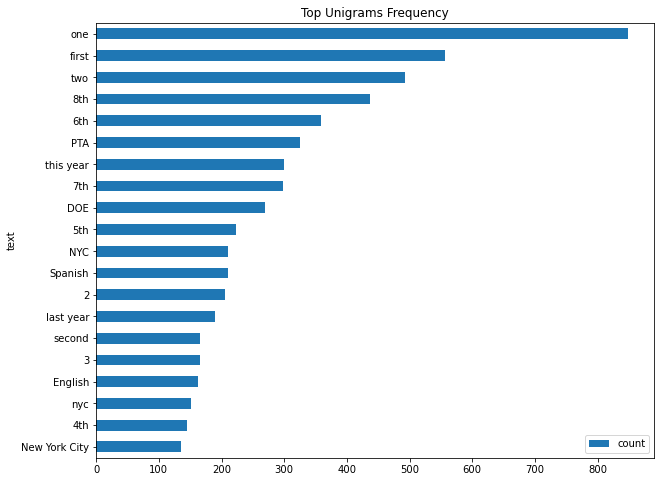

In [71]:
unigrams_df.plot.barh(x='text', y='count', title='Top Entities Frequency', figsize=(10,8)).invert_yaxis()

### People

In [57]:
# NER for people
person_list = []

for ent in tokens.ents:
    if ent.label_ == 'PERSON':
        person_list.append(ent.text)
        
person_counts = Counter(person_list).most_common(20)
df_person = pd.DataFrame(person_counts, columns =['text', 'count'])
df_person

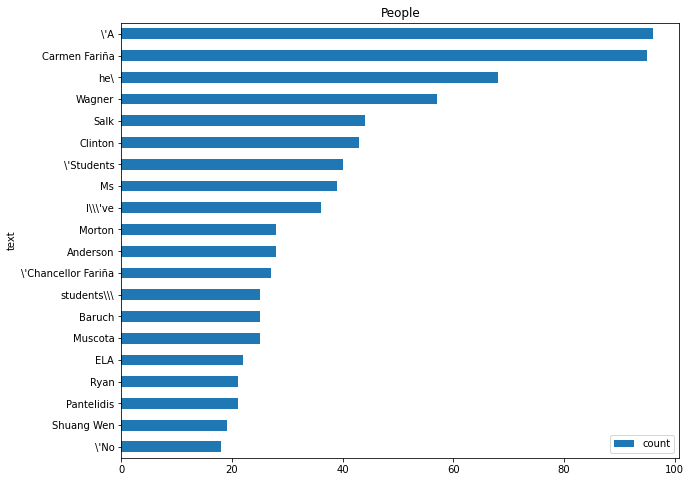

In [65]:
df_person.plot.barh(x='text', y='count', title="People", figsize=(10,8)).invert_yaxis()

### Nationalities or Religious/Political Groups

In [121]:
# NER for nationalities or religious or political groups 
norp_list = []

for ent in tokens.ents:
    if ent.label_ == 'NORP':
        person_list.append(ent.text)
        
norp_counts = Counter(norp_list).most_common(20)
df_norp = pd.DataFrame(norp_counts, columns =['entity', 'count'])
df_norp

,entity,count
